<h1 style="background-color:#af318e;font-family:Serif;font-size:300%;color: #000;text-align:center;border-radius: 50px 50px;">Color Matching</h1>

In [280]:
import csv
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from ColorClassifier import  ColorClassifier

## Dataset Generation

In [4]:
def generate_colored_dataset(num_elements):
    colored_dataset = []

    for _ in range(num_elements):
        random_color = "#{:06X}".format(random.randint(0, 0xFFFFFF))

        # Sélectionner une étiquette en fonction de la luminosité de la couleur
        luminance = (0.299 * int(random_color[1:3], 16) + 0.587 * int(random_color[3:5], 16) + 0.114 * int(random_color[5:7], 16)) / 255
        if (luminance<0.1): label = 0
        elif (luminance<0.2): label = 1
        elif (luminance<0.3): label = 2
        elif (luminance<0.4): label = 3
        elif (luminance<0.5): label = 4
        elif (luminance<0.6): label = 5
        elif (luminance<0.7): label = 6
        elif (luminance<0.8): label = 7
        elif (luminance<0.9): label = 8
        else: label = 9
        
        colored_dataset.append((random_color, label))

    return colored_dataset

# Génération
dataset_size = 1000
color_dataset = generate_colored_dataset(dataset_size)

len(color_dataset)

1000

In [5]:
# Enregistrer le dataset dans un fichier CSV
csv_filename = 'color_dataset.csv'
with open(csv_filename, 'w', newline='') as csvfile:
    fieldnames = ['couleur', 'etiquette']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for color, label in color_dataset:
        writer.writerow({'couleur': color, 'etiquette': label})

print(f"Le dataset a été enregistré dans {csv_filename}")

Le dataset a été enregistré dans color_dataset.csv


In [24]:
df = pd.read_csv('color_dataset.csv')
df.head()

,couleur,etiquette
0,#63ADBB,5
1,#60A37C,5
2,#178F2D,3
3,#610D19,1
4,#5C114D,1


## Data Processing

In [7]:
X = df['couleur']
y = df['etiquette']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# valeurs RGB des couleurs hexadécimales
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return np.array([int(hex_color[i:i+2], 16) for i in (0, 2, 4)])

# Appliquer la fonction pour obtenir les valeurs RVB pour chaque couleur
X_train_rgb = np.array([hex_to_rgb(color) for color in X_train])
X_test_rgb = np.array([hex_to_rgb(color) for color in X_test])

# Normaliser les valeurs RGB
X_train_rgb = X_train_rgb / 255.0
X_test_rgb = X_test_rgb / 255.0

# Convertir les données en tensors PyTorch
X_train_tensor = torch.FloatTensor(X_train_rgb)
y_train_tensor = torch.LongTensor(y_train.values)
X_test_tensor = torch.FloatTensor(X_test_rgb)
y_test_tensor = torch.LongTensor(y_test.values)


torch.Size([200])

## DataLoader

In [8]:
class ColorDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [279]:

color_dataset = ColorDataset(X_train_tensor, y_train_tensor)

batch_size = 100
dataloader = DataLoader(color_dataset, batch_size=batch_size, shuffle=True)


## Model Architecture

In [252]:
model = ColorClassifier()
model

ColorClassifier(
  (fc1): Linear(in_features=3, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
  (fn1): ReLU()
)

## HyperParamaters

In [253]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

## Train and Evaluate function

In [254]:
losses = []
accuracies = []

def train_evaluate(n_epochs):
    for epoch in range(n_epochs):   
        losse = 0   
        for i, (inputs, labels) in enumerate(dataloader, 1):
            model.train()
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losse = losse + loss.item()
        

        with torch.no_grad():
            model.eval()
            outputs = model(X_test_tensor)
            _, predicted = torch.max(outputs, 1)
            accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
            

        # Afficher la perte pour chaque epoch
        if (epoch+1) %50==0:
            print(f" Epoch: [{epoch+1}/ {n_epochs}], Loss: {loss.item()}, Accuracy: {accuracy* 100:.2f}")
            
            losse = np.mean(losse)  
            losses.append(losse)

            accuracies.append(accuracy)
           

    



## Visualization

In [249]:
def visualization(losses, accuracies):
    plt.figure(figsize=(12, 4))
   
    plt.subplot(1, 2, 1)
    plt.title('Loss of train')
    plt.plot(losses, label=' Loss', color='red')

    plt.subplot(1,2,2)
    plt.plot(accuracies, label='Accuracy', color='green')
    plt.title('Accuracy of evaluation')

    plt.legend()
    plt.show()

In [255]:
train_evaluate(500)

 Epoch: [50/ 500], Loss: 0.17617949843406677, Accuracy: 95.50
 Epoch: [100/ 500], Loss: 0.12506696581840515, Accuracy: 95.50
 Epoch: [150/ 500], Loss: 0.08278118073940277, Accuracy: 98.50
 Epoch: [200/ 500], Loss: 0.07976917922496796, Accuracy: 97.50
 Epoch: [250/ 500], Loss: 0.0695861279964447, Accuracy: 99.00
 Epoch: [300/ 500], Loss: 0.05704731494188309, Accuracy: 97.00
 Epoch: [350/ 500], Loss: 0.05404679849743843, Accuracy: 98.50
 Epoch: [400/ 500], Loss: 0.0722430944442749, Accuracy: 98.00
 Epoch: [450/ 500], Loss: 0.10005447268486023, Accuracy: 97.50
 Epoch: [500/ 500], Loss: 0.03403864800930023, Accuracy: 97.50


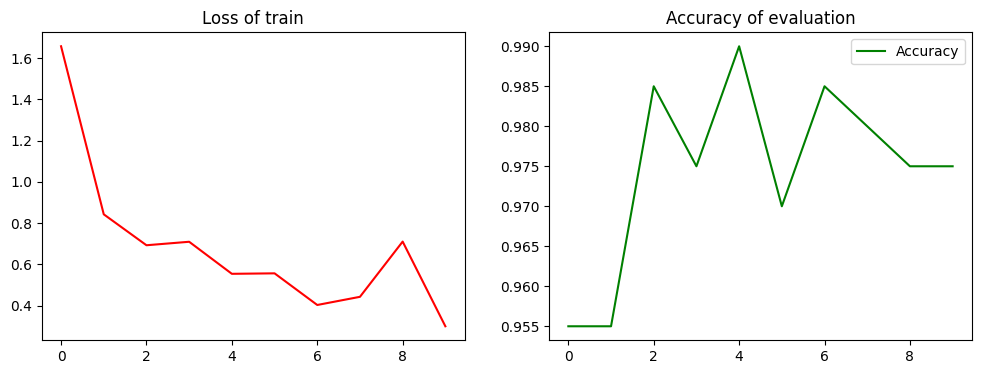

In [256]:
visualization(losses, accuracies)

## Saving to next use

In [277]:
torch.save(model.state_dict(), 'ColorMatching.pth')